
## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



Enter the date (e.g., 2024-06-24 18:00):  2024-07-08 12:00
Enter the maximum forecast hour (For 0, 6, 12, 18z, its 48, anything else it's 18):  0


Select a region:
1. North Central
2. Central
3. South Central
4. Midwestern
5. Ohio Valley
6. Mid Atlantic
7. Northeastern
8. Southeastern
9. Northwestern
10. Southwestern
11. Rocky Mountain
12. Upper Great Lakes
13. Plains
14. Conus


Enter the number of the region:  4


Select a variable:
1. MLCAPE
2. MUCAPE
3. SBCAPE
4. helcy3
5. hlcy_ml
6. hlcy_mu
7. hlcy_sb
8. UVV
9. ABSV
10. QPF
11. uphl
12. sfc
13. TE
14. gh
15. LI
16. LCL
17. STP
18. PBL
19. THESHR
20. GSWIND


Enter the number of the variable:  19


✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2024-Jul-08 12:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [C:\Users\thewe\data\hrrr\20240708]
Downloaded temp (lcl) file for fxx=0: C:\Users\thewe\data\hrrr\20240708\subset_d0ef7d97__hrrr.t12z.wrfsfcf00.grib2
Downloaded dpt (lcl) file for fxx=0: C:\Users\thewe\data\hrrr\20240708\subset_d0ef7d97__hrrr.t12z.wrfsfcf00.grib2
Downloaded pres (lcl) file for fxx=0: C:\Users\thewe\data\hrrr\20240708\subset_d0ef7a9f__hrrr.t12z.wrfsfcf00.grib2
Downloaded vvcsh file for fxx=0: C:\Users\thewe\data\hrrr\20240708\subset_d0efa92d__hrrr.t12z.wrfsfcf00.grib2
Downloaded vucsh file for fxx=0: C:\Users\thewe\data\hrrr\20240708\subset_d0efa92d__hrrr.t12z.wrfsfcf00.grib2
Creating frame for fxx=0 with keyword=THESHR
Processing THESHR for fxx=0
Variables in ds_pres for fxx=0: ['time', 'step', 'meanSea', 'latitude', 'longitude', 'valid_time', 'mslma']
Animated GIF saved as THESHR_animation.gif


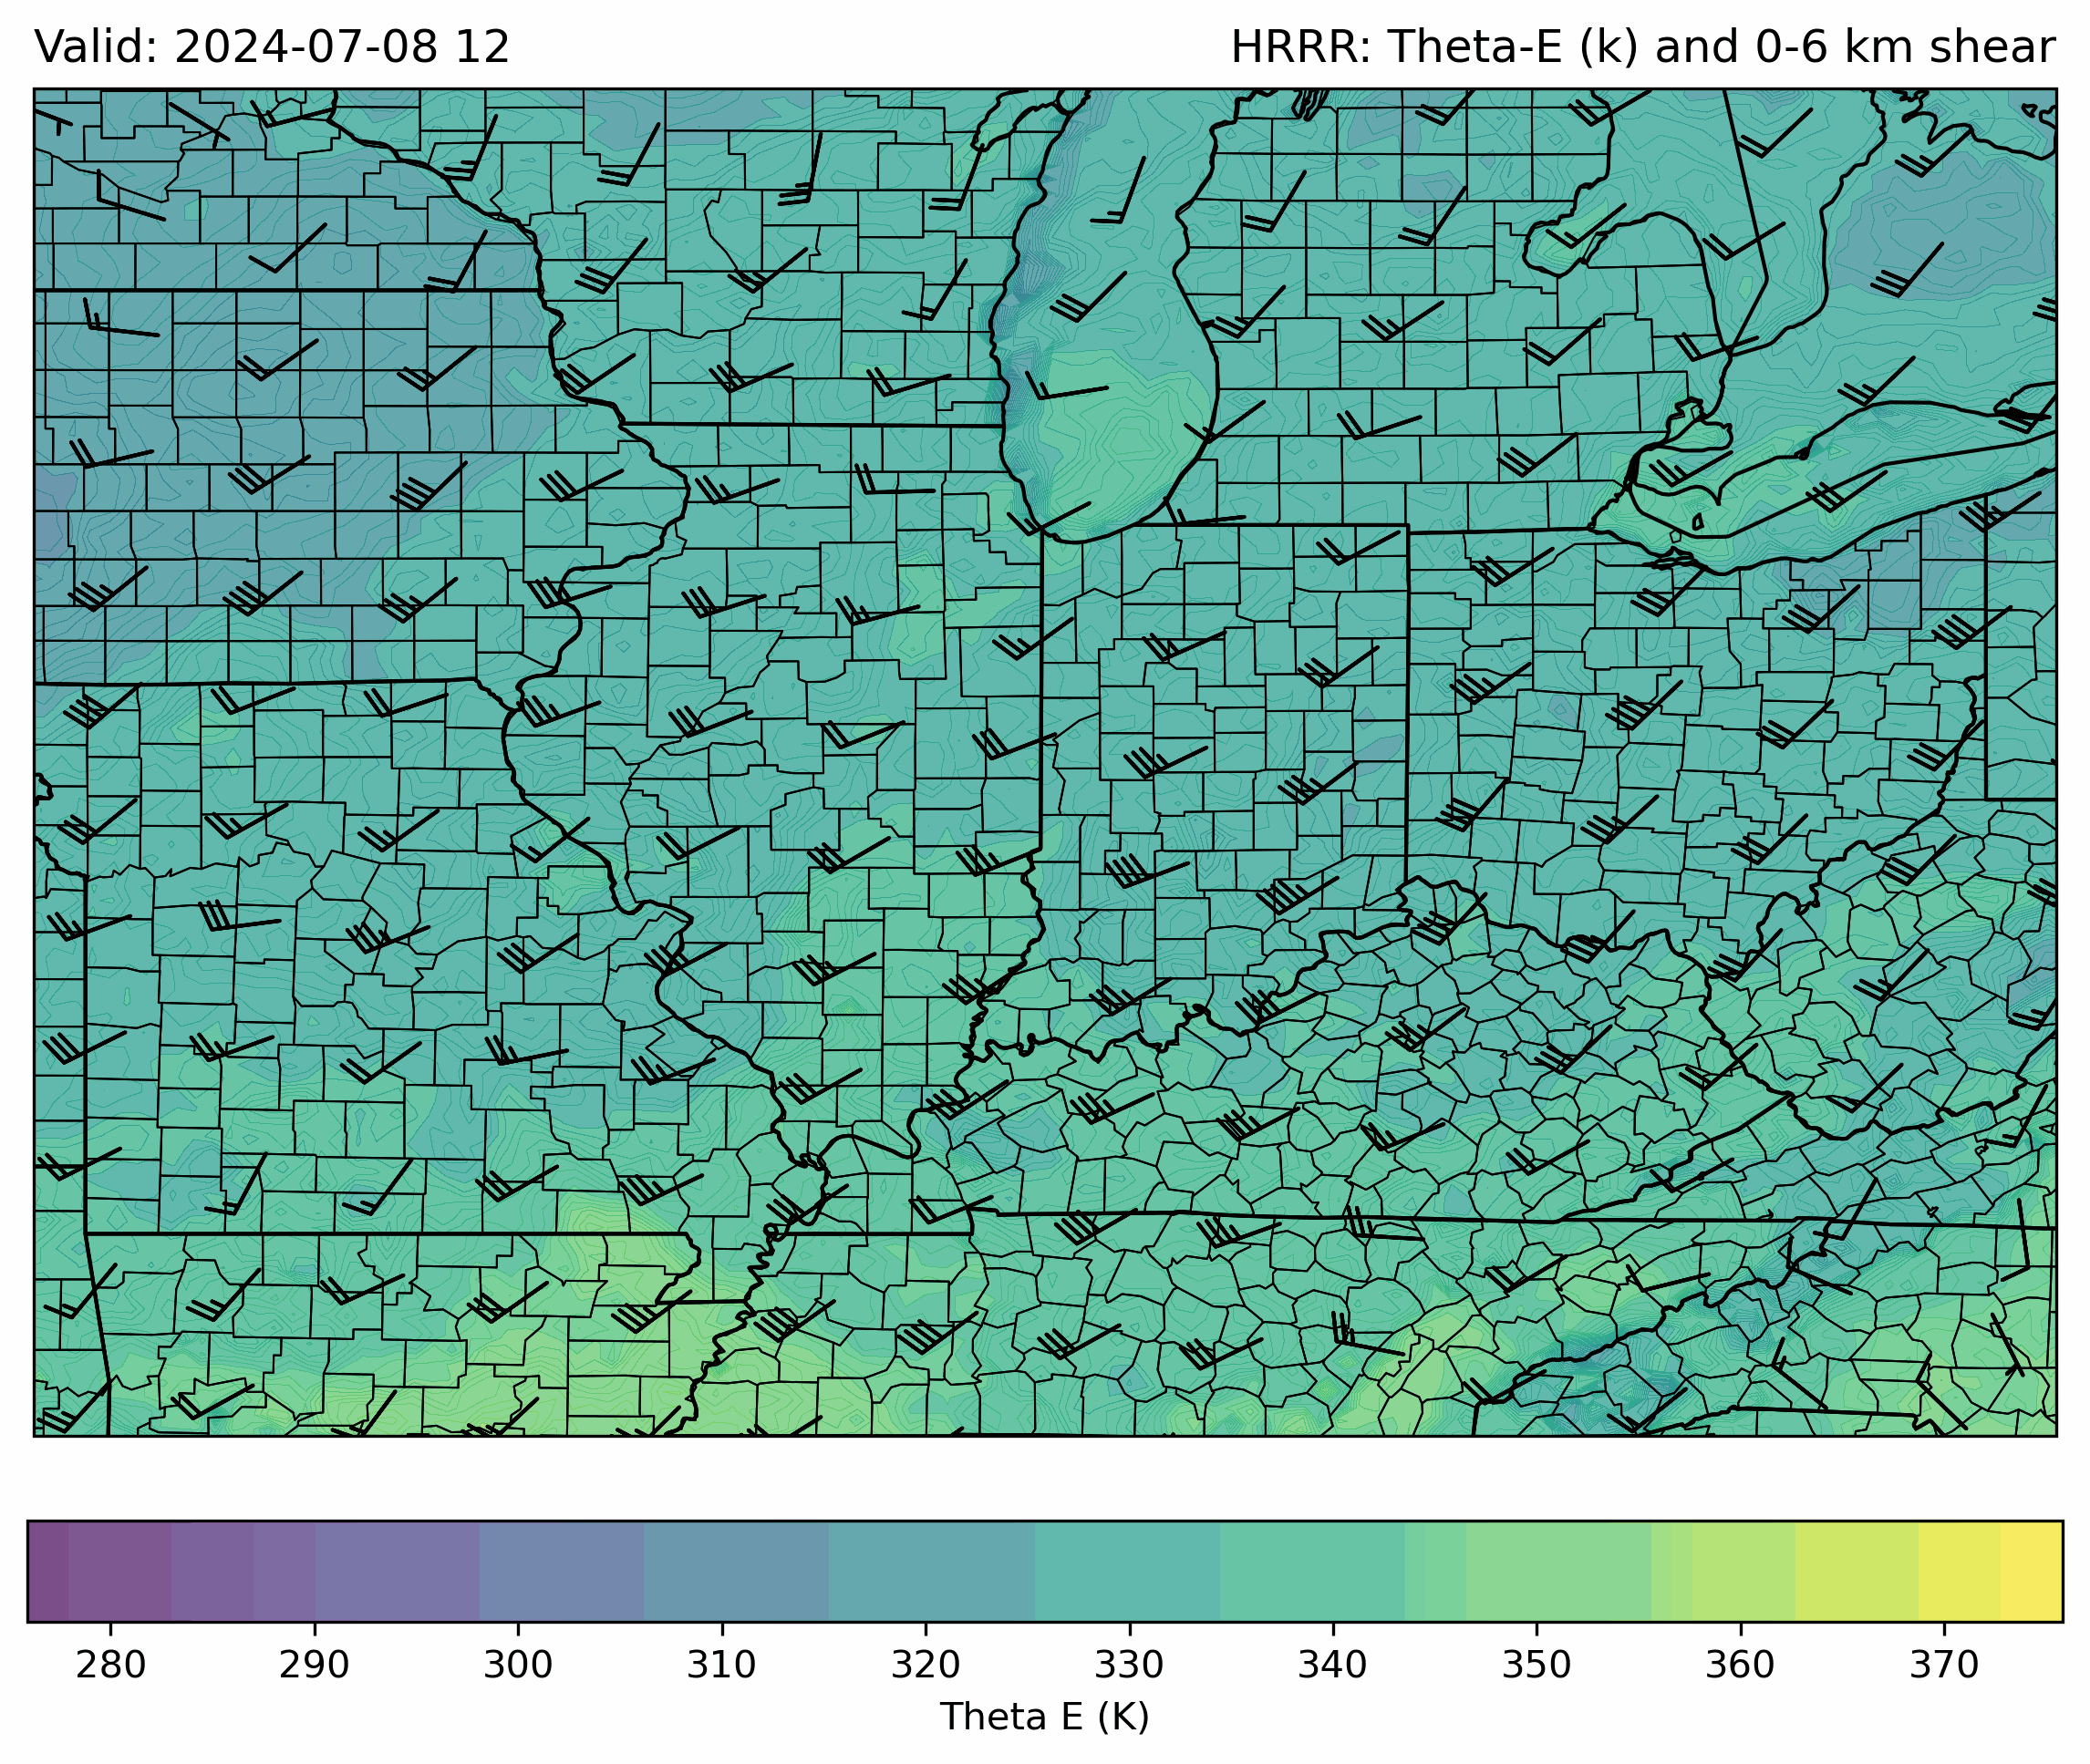

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from PIL import Image
import xarray as xr
from herbie import Herbie
from matplotlib.ticker import MaxNLocator
from IPython.display import display, Image as IPImage
from metpy.plots import USCOUNTIES
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
from scipy.ndimage import gaussian_filter
from metpy.calc import equivalent_potential_temperature, lcl, significant_tornado, wind_components
from metpy.units import units

MS_TO_KNOTS = 1.94384

regions = {
    "north_central": (-105.0, -90.0, 40.0, 49.0),
    "central": (-100.0, -85.0, 35.0, 45.0),
    "south_central": (-100.0, -85.0, 30.0, 40.0),
    "midwestern": (-95.0, -80.0, 35.0, 45.0),
    "ohio_valley": (-90.0, -75.0, 35.0, 45.0),
    "mid_atlantic": (-85.0, -70.0, 35.0, 45.0),
    "northeastern": (-80.0, -65.0, 40.0, 50.0),
    "southeastern": (-90.0, -75.0, 25.0, 35.0),
    "northwestern": (-125.0, -110.0, 40.0, 50.0),
    "southwestern": (-125.0, -110.0, 30.0, 40.0),
    "rocky_mountain": (-115.0, -100.0, 35.0, 45.0),
    "upper_great_lakes": (-95.0, -80.0, 40.0, 50.0),
    "plains": (-105.0, -90.0, 35.0, 45.0),
    "conus": (-125, -67, 24, 50)
}

def get_pressure_level(keyword):
    keyword_mapping = {
        "ML": "255-0 mb above ground",
        "MU": "180-0 mb above ground",
        "SB": "90-0 mb above ground"
    }
    return keyword_mapping.get(keyword, "180-0 mb above ground")

def get_variable_name(keyword, level=None):
    variable_mapping = {
        "MLCAPE": "CAPE",
        "MUCAPE": "CAPE",
        "SBCAPE": "CAPE",
        "hlcy_ml": (":3000-0 m above ground", "CAPE:255-0 mb above ground"),
        "hlcy_mu": (":3000-0 m above ground", "CAPE:180-0 mb above ground"),
        "hlcy_sb": (":3000-0 m above ground", "CAPE:90-0 mb above ground"),
        "UVV": (f":{level} mb", f":{level} mb"),
        "ABSV": (f":{level} mb", f":{level} mb"),
        "QPF": "APCP:surface",
        "uphl": ("MXUPHL:5000-2000 m above ground", "REFC:entire atmosphere"),
        "sfc": ("2 m above ground", "2 m above ground", "10 m above ground", "10 m above ground"),
        "TE": ("2 m above ground", "2 m above ground", "10 m above ground", "10 m above ground", ":mean sea level"),
        "gh": (f":{level} mb", f":{level} mb", f":{level} mb"),
        "helcy3": ":3000-0 m above ground",
        "LI": ":500-1000 mb",
        "LCL": (":2 m above ground", ":2 m above ground", ":surface"),
        "STP": (":2 m above ground", ":2 m above ground", ":surface", ":1000-0 m above ground",":90-0 mb above ground", ":0-6000 m above ground", ":0-6000 m above ground"),
        "PBL": (":surface"),
        "THESHR": ("2 m above ground", "2 m above ground", ":mean sea level",":0-6000 m above ground", ":0-6000 m above ground")
    }
    return variable_mapping.get(keyword)

def downsample_data(data, step):
    return data[::step, ::step]

def download_files(date, model, max_fxx, extent, keyword, level=None):
    base_dir = "downloaded_files"
    os.makedirs(base_dir, exist_ok=True)

    file_paths = {
        'cape': [], 'cin': [], 'hlcy': [], 'gh': [], 'uvv': [], 'absv': [], 
        'precip': [], 'uphl': [], 'refc': [], 'temp': [], 'dpt': [], 'pres': [], 
        'winds': [], 'winds2': [], 'helcy':[], 'lift':[], 'vvcsh':[], 'vucsh':[], 'pbl':[]
    }
    
    variables = get_variable_name(keyword, level)
    cape_var, cin_var, helcy_var, hlcy_var, gh_var, uvv_var, absv_var, precip_var, uphl_var, refc_var, lif_var, pbl_var= None, None, None, None, None, None, None, None, None, None, None, None
    temp_var, dpt_var, pres_var, winds_var, winds2_var, vvcsh_var, vucsh_var = None, None, None, None, None, None, None

    if isinstance(variables, tuple):
        if "hlcy" in keyword:
            hlcy_var, cape_var = variables
            cin_var = f"CIN:{cape_var.split(':')[-1]}"  # CIN variable
            product = 'prs'
        elif "uphl" in keyword:
            uphl_var, refc_var = variables
            product = 'prs'
        elif "sfc" in keyword or "TE" in keyword:
            temp_var, dpt_var, winds_var, winds2_var = variables[:4]
            if "TE" in keyword:
                pres_var = variables[4]
            product = 'sfc'
        elif "gh" in keyword:
            gh_var, winds_var, winds2_var = variables
            product = 'prs'
        elif "LCL" in keyword:
            temp_var, dpt_var, pres_var = variables
            product = 'sfc'
        elif "STP" in keyword:
            temp_var, dpt_var, pres_var, hlcy_var, cape_var, vvcsh_var, vucsh_var = variables
            product = 'prs'
        elif "THESHR" in keyword:
            temp_var, dpt_var, pres_var, vvcsh_var, vucsh_var = variables
            product = 'sfc'
        else:
            gh_var, second_var = variables
            if "ABSV" in keyword:
                absv_var = second_var
                product = 'prs'
            else:
                uvv_var = second_var
                product = 'prs'
    elif keyword == "QPF":
        precip_var = variables
        product = 'sfc'
    elif keyword == "helcy3":
        helcy_var = variables
        product = 'sfc'
    elif keyword == 'PBL':
        pbl_var = variables
        product = 'sfc'
    elif keyword == "LI":
        lif_var = variables
        product = 'sfc'
    else:
        cape_var = f"CAPE:{get_pressure_level(keyword)}"
        cin_var = f"CIN:{get_pressure_level(keyword)}"
        product = 'prs'

    for fxx in range(max_fxx + 1):
        H = Herbie(date, model=model, product=product, fxx=fxx)

        if cape_var:
            H.download(cape_var)
            file_path_cape = H.get_localFilePath(cape_var)
            file_paths['cape'].append(file_path_cape)
            print(f"Downloaded cape file for fxx={fxx}: {file_path_cape}")

        if cin_var and 'hlcy' not in keyword:
            H.download(cin_var)
            file_path_cin = H.get_localFilePath(cin_var)
            file_paths['cin'].append(file_path_cin)
            print(f"Downloaded cin file for fxx={fxx}: {file_path_cin}")

        if hlcy_var:
            H.download(hlcy_var)
            file_path_hlcy = H.get_localFilePath(hlcy_var)
            file_paths['hlcy'].append(file_path_hlcy)
            print(f"Downloaded hlcy file for fxx={fxx}: {file_path_hlcy}")
        
        if helcy_var:
            H.download(helcy_var)
            file_path_helcy = H.get_localFilePath(helcy_var)
            file_paths['helcy'].append(file_path_helcy)
            print(f"Downloaded helcy file for fxx={fxx}: {file_path_helcy}")

        if gh_var:
            H.download(gh_var)
            file_path_gh = H.get_localFilePath(gh_var)
            file_paths['gh'].append(file_path_gh)
            print(f"Downloaded gh file for fxx={fxx}: {file_path_gh}")

        if uvv_var:
            H.download(uvv_var)
            file_path_uvv = H.get_localFilePath(uvv_var)
            file_paths['uvv'].append(file_path_uvv)
            print(f"Downloaded uvv file for fxx={fxx}: {file_path_uvv}")

        if absv_var:
            H.download(absv_var)
            file_path_absv = H.get_localFilePath(absv_var)
            file_paths['absv'].append(file_path_absv)
            print(f"Downloaded absv file for fxx={fxx}: {file_path_absv}")

        if precip_var:
            H.download(precip_var)
            file_path_precip = H.get_localFilePath(precip_var)
            file_paths['precip'].append(file_path_precip)
            print(f"Downloaded precip file for fxx={fxx}: {file_path_precip}")
            
        if uphl_var:
            H.download(uphl_var)
            file_path_uphl = H.get_localFilePath(uphl_var)
            file_paths['uphl'].append(file_path_uphl)
            print(f"Downloaded uphl file for fxx={fxx}: {file_path_uphl}")

        if refc_var:
            H.download(refc_var)
            file_path_refc = H.get_localFilePath(refc_var)
            file_paths['refc'].append(file_path_refc)
            print(f"Downloaded refc file for fxx={fxx}: {file_path_refc}")
            
        if temp_var:
            H.download(temp_var)
            file_path_temp = H.get_localFilePath(temp_var)
            file_paths['temp'].append(file_path_temp)
            print(f"Downloaded temp (lcl) file for fxx={fxx}: {file_path_temp}")
            
        if dpt_var:
            H.download(dpt_var)
            file_path_dpt = H.get_localFilePath(dpt_var)
            file_paths['dpt'].append(file_path_dpt)
            print(f"Downloaded dpt (lcl) file for fxx={fxx}: {file_path_dpt}")
            
        if pres_var:
            H.download(pres_var)
            file_path_pres = H.get_localFilePath(pres_var)
            file_paths['pres'].append(file_path_pres)
            print(f"Downloaded pres (lcl) file for fxx={fxx}: {file_path_pres}")
            
        if winds_var:
            H.download(winds_var)
            file_path_winds = H.get_localFilePath(winds_var)
            file_paths['winds'].append(file_path_winds)
            print(f"Downloaded winds file for fxx={fxx}: {file_path_winds}")

        if winds2_var:
            H.download(winds2_var)
            file_path_winds2 = H.get_localFilePath(winds2_var)
            file_paths['winds2'].append(file_path_winds2)
            print(f"Downloaded winds2 file for fxx={fxx}: {file_path_winds2}")
            
        if vvcsh_var:
            H.download(vvcsh_var)
            file_path_vvcsh = H.get_localFilePath(vvcsh_var)
            file_paths['vvcsh'].append(file_path_vvcsh)
            print(f"Downloaded vvcsh file for fxx={fxx}: {file_path_vvcsh}")

        if vucsh_var:
            H.download(vucsh_var)
            file_path_vucsh = H.get_localFilePath(vucsh_var)
            file_paths['vucsh'].append(file_path_vucsh)
            print(f"Downloaded vucsh file for fxx={fxx}: {file_path_vucsh}")

        if lif_var:
            H.download(lif_var)
            file_path_lif = H.get_localFilePath(lif_var)
            file_paths['lift'].append(file_path_lif)
            print(f"Downloaded lif file for fxx={fxx}: {file_path_lif}")
        if pbl_var:
            H.download(pbl_var)
            file_path_pbl = H.get_localFilePath(pbl_var)
            file_paths['pbl'].append(file_path_pbl)
            print(f"Downloaded pbl file for fxx={fxx}: {file_path_pbl}")

    return file_paths

def create_custom_colormap():
    colors = [(0, 'blue'), (0.5, 'white'), (1, 'red')]
    cmap_name = 'custom_bwr'
    return LinearSegmentedColormap.from_list(cmap_name, colors, N=256)

def create_gray_colormap():
    colors = [(0.25, 0.25, 0.25)] * 256
    return LinearSegmentedColormap.from_list('gray_cmap', colors, N=256)

def round_to_multiple(value, multiple):
    return multiple * round(value / multiple)
def pressure_to_height(pressure_hPa):
    # Constants for the barometric formula
    T0 = 288.15  # Standard temperature at sea level in K
    L = 0.0065   # Temperature lapse rate in K/m
    P0 = 1013.25  # Standard pressure at sea level in hPa
    g = 9.80665  # Gravitational acceleration in m/s^2
    R = 287.05   # Specific gas constant for dry air in J/(kg·K)

    height_m = (T0 / L) * (1 - (pressure_hPa / P0) ** (R * L / g))
    return height_m

def create_frame(file_paths, fxx, output_dir, extent, step, init_time, model_name, cape_min, cape_max, cin_min, cin_max, keyword, uvv_min, uvv_max, absv_min, absv_max, tp_min, tp_max, tempf_min, tempf_max, barb_step, theta_e_min, theta_e_max, wind_speed_max, hlcy_min, hlcy_max, lift_min, lift_max, lcl_min, lcl_max, pbl_min, pbl_max, level=None):
    fig = plt.figure(figsize=[12, 8], dpi=300)
    ax = plt.axes(projection=ccrs.PlateCarree())

    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.STATES, linewidth=1, edgecolor='black')
    ax.add_feature(cfeature.COASTLINE, linewidth=1, edgecolor='black')
    ax.add_feature(cfeature.BORDERS, linewidth=1, edgecolor='black')
    ax.add_feature(USCOUNTIES, linewidth=0.5, edgecolor='black')

    print(f"Creating frame for fxx={fxx} with keyword={keyword}")

    try:
        if 'hlcy' in keyword:
            print("Processing hlcy data")
            file_hlcy = file_paths['hlcy'][fxx]
            ds_hlcy = xr.open_dataset(file_hlcy, engine='cfgrib', filter_by_keys={'stepType': 'instant'})
            hlcy = ds_hlcy.hlcy.values
            lon = ds_hlcy.longitude.values
            lat = ds_hlcy.latitude.values

            if hlcy.ndim == 3:
                hlcy = hlcy[0, :, :]  # Selecting the first level/time step

            lon_ds = downsample_data(lon, step)
            lat_ds = downsample_data(lat, step)
            hlcy_ds = downsample_data(hlcy, step)
        
        if 'helcy3' in keyword:
            print("Processing helcy3 data")
            file_hlcy = file_paths['helcy'][fxx]
            ds_hlcy = xr.open_dataset(file_hlcy, engine='cfgrib', filter_by_keys={'stepType': 'instant'})
            hlcy = ds_hlcy['hlcy'].values
            lon = ds_hlcy.longitude.values
            lat = ds_hlcy.latitude.values

            if hlcy.ndim == 3:
                hlcy = hlcy[0, :, :]  # Selecting the first level/time step

            lon_ds = downsample_data(lon, step)
            lat_ds = downsample_data(lat, step)
            hlcy_ds = downsample_data(hlcy, step)
            print(f"hlcy_ds shape: {hlcy_ds.shape}, lon_ds shape: {lon_ds.shape}, lat_ds shape: {lat_ds.shape}")
        
        if 'LI' in keyword:
            print("Processing LI data")
            file_lif = file_paths['lift'][fxx]
            ds_lift = xr.open_dataset(file_lif, engine='cfgrib', filter_by_keys={'stepType': 'instant'})
            lift_ds = ds_lift['lftx'].values 
            print(f"Values for LI are {lift_ds}.")
            lon_ds = ds_lift.longitude.values
            lat_ds = ds_lift.latitude.values
            print(f"lift_ds shape: {lift_ds.shape}, lon_ds shape: {lon_ds.shape}, lat_ds shape: {lat_ds.shape}")
        if 'PBL' in keyword:
            print("Processing PBL data")
            file_pbl = file_paths['pbl'][fxx]
            ds_pbl = xr.open_dataset(file_pbl, engine='cfgrib', filter_by_keys={'stepType': 'instant'})
            pbl_ds = ds_pbl['blh'].values 
            print(f"Values for blh are {pbl_ds}.")
            lon_ds = ds_pbl.longitude.values
            lat_ds = ds_pbl.latitude.values
            print(f"pbl_;ds shape: {pbl_ds.shape}, lon_ds shape: {lon_ds.shape}, lat_ds shape: {lat_ds.shape}")
        
        if 'CAPE' in keyword and 'STP' not in keyword or ('cape' in file_paths and file_paths['cape'] and 'STP' not in keyword):
            print("Processing CAPE data")
            file_cape = file_paths['cape'][fxx]
            ds_cape = xr.open_dataset(file_cape, engine='cfgrib', filter_by_keys={'stepType': 'instant'})
            if 'cape' in ds_cape:
                cape = ds_cape.cape.values
                lon = ds_cape.longitude.values
                lat = ds_cape.latitude.values

                lon_ds = downsample_data(lon, step)
                lat_ds = downsample_data(lat, step)
                cape_ds = downsample_data(cape, step)

                if 'cin' in file_paths and len(file_paths['cin']) > 0:
                    print("Processing CIN data")
                    file_cin = file_paths['cin'][fxx]
                    ds_cin = xr.open_dataset(file_cin, engine='cfgrib', filter_by_keys={'stepType': 'instant'})
                    cin = ds_cin.cin.values

                    cin_ds = downsample_data(cin, step)
        
        if 'UVV' in keyword:
            print("Processing UVV data")
            file_gh = file_paths['gh'][fxx]
            ds_gh = xr.open_dataset(file_gh, engine='cfgrib', filter_by_keys={'stepType': 'instant'})
            gh = ds_gh.gh.values
            lon = ds_gh.longitude.values
            lat = ds_gh.latitude.values

            lon_ds = downsample_data(lon, step)
            lat_ds = downsample_data(lat, step)
            gh_ds = downsample_data(gh, step)

            file_uvv = file_paths['uvv'][fxx]
            ds_uvv = xr.open_dataset(file_uvv, engine='cfgrib', filter_by_keys={'stepType': 'instant'})
            uvv = ds_uvv.w.values  # Assuming 'w' is the variable name for vertical velocity

            uvv_ds = downsample_data(uvv, step)
        
        if 'ABSV' in keyword:
            print("Processing ABSV data")
            file_gh = file_paths['gh'][fxx]
            ds_gh = xr.open_dataset(file_gh, engine='cfgrib', filter_by_keys={'stepType': 'instant'})
            gh = ds_gh.gh.values
            lon = ds_gh.longitude.values
            lat = ds_gh.latitude.values

            lon_ds = downsample_data(lon, step)
            lat_ds = downsample_data(lat, step)
            gh_ds = downsample_data(gh, step)

            try:
                file_absv = file_paths['absv'][fxx]
                ds_absv = xr.open_dataset(file_absv, engine='cfgrib', filter_by_keys={'stepType': 'instant'})
                if 'absv' not in ds_absv.variables:
                    raise KeyError(f"absv variable not found in dataset for fxx={fxx}")
                absv = ds_absv.absv.values  # Assuming 'absv' is the variable name for absolute vorticity
            except (IndexError, KeyError) as e:
                print(f"Error processing ABSV data for fxx={fxx}: {e}")
                return None

            absv_ds = downsample_data(absv, step)
        
        if 'QPF' in keyword:
            print("Processing QPF data")
            file_precip = file_paths['precip'][fxx]
            ds_precip = xr.open_dataset(file_precip, engine='cfgrib', filter_by_keys={'stepType': 'accum'})
            tp = ds_precip.tp.values * 0.0393701  # Convert from kg m**-2 to inches
            lon = ds_precip.longitude.values
            lat = ds_precip.latitude.values

            lon_ds = downsample_data(lon, step)
            lat_ds = downsample_data(lat, step)
            tp_ds = downsample_data(tp, step)
        
        if 'uphl' in keyword:
            print("Processing uphl data")
            try:
                file_uphl = file_paths['uphl'][fxx]
                ds_uphl = xr.open_dataset(file_uphl, engine='cfgrib', filter_by_keys={'stepType': 'max'})
                if 'unknown' not in ds_uphl.variables:
                    raise KeyError(f"uphl variable not found in dataset for fxx={fxx}")
                uphl = ds_uphl.unknown.values
            except (IndexError, KeyError) as e:
                print(f"Error processing uphl data for fxx={fxx}: {e}")
                return None

            lon_ds = ds_uphl.longitude.values  # No downsampling for uphl
            lat_ds = ds_uphl.latitude.values  # No downsampling for uphl
            uphl_ds = uphl  # No downsampling for uphl

            file_refc = file_paths['refc'][fxx]
            ds_refc = xr.open_dataset(file_refc, engine='cfgrib', filter_by_keys={'stepType': 'instant'})
            refc = ds_refc.refc.values

            refc_ds = refc  # No downsampling for refc
        
        if 'sfc' in keyword or 'TE' in keyword:
            print("Processing sfc or TE data")
            file_temp = file_paths['temp'][fxx]
            ds_temp = xr.open_dataset(file_temp, engine='cfgrib', filter_by_keys={'stepType': 'instant'})
            temp = ds_temp.t2m.values 
            tempf = (temp - 273.15) * 9/5 + 32  # Convert from Kelvin to Fahrenheit
            lon_ds = ds_temp.longitude.values  # No downsampling for temperature
            lat_ds = ds_temp.latitude.values
            
            file_dpt = file_paths['dpt'][fxx]
            ds_dpt = xr.open_dataset(file_dpt, engine='cfgrib', filter_by_keys={'stepType': 'instant'})
            dpt = ds_dpt.d2m.values
            dptf = (dpt - 273.15) * 9/5 + 32  # Convert from Kelvin to Fahrenheit
            dptf_smooth = gaussian_filter(dptf, sigma=3)  # Gaussian smoothing
            
            file_wind = file_paths['winds'][fxx]
            file_wind2 = file_paths['winds2'][fxx]
            ds_winds = xr.open_dataset(file_wind, engine='cfgrib', filter_by_keys={'stepType': 'instant'})
            ds_winds2 = xr.open_dataset(file_wind2, engine='cfgrib', filter_by_keys={'stepType': 'instant'})
            u10 = ds_winds.u10.values * MS_TO_KNOTS
            v10 = ds_winds2.v10.values * MS_TO_KNOTS
            wind_speed = np.sqrt(u10**2 + v10**2)

            tempf_ds = downsample_data(tempf, step)
            dptf_ds = downsample_data(dptf_smooth, step)
            u10_ds = downsample_data(u10, step)
            v10_ds = downsample_data(v10, step)

            lon_ds = lon_ds[::step, ::step]
            lat_ds = lat_ds[::step, ::step]
            
            if 'TE' in keyword:
                print("Processing TE data")
                file_pres = file_paths['pres'][fxx]
                ds_pres = xr.open_dataset(file_pres, engine='cfgrib', filter_by_keys={'stepType': 'instant'})
                pres = ds_pres.mslma.values / 100  # Convert to hPa
                pres_ds = downsample_data(pres, step)

                # Adjust units for equivalent_potential_temperature calculation
                tempf_units = (tempf_ds - 32) * (5/9) + 273.15  # Convert from Fahrenheit to Kelvin
                dptf_units = (dptf_ds - 32) * (5/9) + 273.15  # Convert from Fahrenheit to Kelvin
                
                theta_e = equivalent_potential_temperature(pres_ds * units.hPa, tempf_units * units.kelvin, dptf_units * units.kelvin)
                theta_e_ds = theta_e.magnitude
        if 'LCL' in keyword:
            print(f"Processing LCL for fxx={fxx}")
            file_temp = file_paths['temp'][fxx]
            ds_temp = xr.open_dataset(file_temp, engine='cfgrib', filter_by_keys={'stepType': 'instant'})
            temp = ds_temp.t2m.values 
            tempC = (temp - 273.15)  # Convert from Kelvin to Celsius
            lon = ds_temp.longitude.values  # No downsampling for temperature
            lat = ds_temp.latitude.values

            file_dpt = file_paths['dpt'][fxx]
            ds_dpt = xr.open_dataset(file_dpt, engine='cfgrib', filter_by_keys={'stepType': 'instant'})
            dpt = ds_dpt.d2m.values
            dptC = (dpt - 273.15)  # Convert from Kelvin to Celsius
            
            file_pres = file_paths['pres'][fxx]
            ds_pres = xr.open_dataset(file_pres, engine='cfgrib', filter_by_keys={'stepType': 'instant'})
            pres = ds_pres.sp.values / 100  # Convert to hP
            
            lclc = lcl(pres * units.hPa, tempC * units.degC, dptC * units.degC)
            lcl_pressure = lclc[0].magnitude
            lcl_height = pressure_to_height(lcl_pressure)
            print(f'Maximum lcl height for {fxx} is {lcl_height.max()}')
            
            print(f"lcl_ds shape: {lcl_height.shape}, lon_ds shape: {lon.shape}, lat_ds shape: {lat.shape}")
            
        if 'gh' in keyword:
            print("Processing gh data")
            file_gh = file_paths['gh'][fxx]
            ds_gh = xr.open_dataset(file_gh, engine='cfgrib', filter_by_keys={'stepType': 'instant'})
            gh = ds_gh.gh.values
            lon = ds_gh.longitude.values
            lat = ds_gh.latitude.values

            file_wind = file_paths['winds'][fxx]
            file_wind2 = file_paths['winds2'][fxx]
            ds_winds = xr.open_dataset(file_wind, engine='cfgrib', filter_by_keys={'stepType': 'instant'})
            ds_winds2 = xr.open_dataset(file_wind2, engine='cfgrib', filter_by_keys={'stepType': 'instant'})
            u = ds_winds.u.values * MS_TO_KNOTS
            v = ds_winds2.v.values * MS_TO_KNOTS

            lon_ds = downsample_data(lon, step)
            lat_ds = downsample_data(lat, step)
            gh_ds = downsample_data(gh, step)
            u_ds = downsample_data(u, step)
            v_ds = downsample_data(v, step)

            wind_speed_500 = np.sqrt(u_ds**2 + v_ds**2)
            wind_speed_500_50kt = np.where(wind_speed_500 >= 25, wind_speed_500, np.nan)
        
        if 'STP' in keyword:
            print(f"Processing STP for fxx={fxx}")

            file_temp = file_paths['temp'][fxx]
            ds_temp = xr.open_dataset(file_temp, engine='cfgrib', filter_by_keys={'stepType': 'instant'})
            temp = ds_temp.t2m.values 
            tempC = (temp - 273.15)  # Convert from Kelvin to Celsius
            lon = ds_temp.longitude.values
            lat = ds_temp.latitude.values

            file_dpt = file_paths['dpt'][fxx]
            ds_dpt = xr.open_dataset(file_dpt, engine='cfgrib', filter_by_keys={'stepType': 'instant'})
            dpt = ds_dpt.d2m.values
            dptC = (dpt - 273.15)  # Convert from Kelvin to Celsius

            try:
                file_pres = file_paths['pres'][fxx]
                ds_pres = xr.open_dataset(file_pres, engine='cfgrib', filter_by_keys={'stepType': 'instant'})
                print(f"Variables in ds_pres for fxx={fxx}: {list(ds_pres.variables.keys())}")
                if 'sp' not in ds_pres.variables:
                    raise KeyError(f"pres variable not found in dataset for fxx={fxx}")
                pres = ds_pres.sp.values / 100 # Convert to hPa
            except (IndexError, KeyError) as e:
                return None

            lclc = lcl(pres * units.hPa, tempC * units.degC, dptC * units.degC)
            lcl_pressure = lclc[0].magnitude
            lcl_height = pressure_to_height(lcl_pressure)

            file_hlcy = file_paths['hlcy'][fxx]
            ds_hlcy = xr.open_dataset(file_hlcy, engine='cfgrib', filter_by_keys={'stepType': 'instant'})
            hlcy = ds_hlcy.hlcy.values

            file_cape = file_paths['cape'][fxx]
            ds_cape = xr.open_dataset(file_cape, engine='cfgrib', filter_by_keys={'stepType': 'instant'})
            cape = ds_cape.cape.values

            file_vvcsh = file_paths['vvcsh'][fxx]
            ds_vvcsh = xr.open_dataset(file_vvcsh, engine='cfgrib', filter_by_keys={'stepType': 'instant'})
            vvcsh = ds_vvcsh.vvcsh.values*MS_TO_KNOTS

            file_vucsh = file_paths['vucsh'][fxx]
            ds_vucsh = xr.open_dataset(file_vucsh, engine='cfgrib', filter_by_keys={'stepType': 'instant'})
            vucsh = ds_vucsh.vucsh.values * MS_TO_KNOTS

            wind_shear = np.sqrt(vucsh**2 + vvcsh**2) 

            stp = significant_tornado(cape * units('J/kg'), lcl_height * units.meter, hlcy * units('m^2/s^2'), wind_shear*units.knot).to_base_units()
            stp = stp.magnitude

            lon_ds = downsample_data(lon, step)
            lat_ds = downsample_data(lat, step)
            stp_ds = downsample_data(stp, step)

            print(f"stp_ds shape: {stp_ds.shape}, lon_ds shape: {lon_ds.shape}, lat_ds shape: {lat_ds.shape}")
        if 'THESHR' in keyword:
            print(f"Processing THESHR for fxx={fxx}")

            file_temp = file_paths['temp'][fxx]
            ds_temp = xr.open_dataset(file_temp, engine='cfgrib', filter_by_keys={'stepType': 'instant'})
            temp = ds_temp.t2m.values   # Convert from Kelvin to Celsius
            lon = ds_temp.longitude.values
            lat = ds_temp.latitude.values

            file_dpt = file_paths['dpt'][fxx]
            ds_dpt = xr.open_dataset(file_dpt, engine='cfgrib', filter_by_keys={'stepType': 'instant'})
            dpt = ds_dpt.d2m.values  # Convert from Kelvin to Celsius

            try:
                file_pres = file_paths['pres'][fxx]
                ds_pres = xr.open_dataset(file_pres, engine='cfgrib', filter_by_keys={'stepType': 'instant'})
                print(f"Variables in ds_pres for fxx={fxx}: {list(ds_pres.variables.keys())}")
                if 'mslma' not in ds_pres.variables:
                    raise KeyError(f"pres variable not found in dataset for fxx={fxx}")
                pres = ds_pres.mslma.values / 100 # Convert to hPa
            except (IndexError, KeyError) as e:
                return None
            file_vvcsh = file_paths['vvcsh'][fxx]
            ds_vvcsh = xr.open_dataset(file_vvcsh, engine='cfgrib', filter_by_keys={'stepType': 'instant'})
            vvcsh = ds_vvcsh.vvcsh.values*MS_TO_KNOTS

            file_vucsh = file_paths['vucsh'][fxx]
            ds_vucsh = xr.open_dataset(file_vucsh, engine='cfgrib', filter_by_keys={'stepType': 'instant'})
            vucsh = ds_vucsh.vucsh.values * MS_TO_KNOTS
            
            temp_ds = downsample_data(temp, step)
            dpt_ds = downsample_data(dpt, step)
            pres_ds = downsample_data(pres, step)
            ushr_ds = downsample_data(vucsh, step)
            vshr_ds = downsample_data(vvcsh, step)

            lon_ds = downsample_data(lon, step)
            lat_ds = downsample_data(lat, step)

            wind_shear = np.sqrt(ushr_ds**2 + vshr_ds**2) 
            theta_e = equivalent_potential_temperature(pres_ds * units.hPa, temp_ds * units.kelvin, dpt_ds * units.kelvin)
            theta_e_ds = theta_e.magnitude
            


        if 'CAPE' in keyword or ('cape' in file_paths and file_paths['cape'] and 'STP' not in keyword):
            assert cape_ds is not None, "cape_ds is None"
        if 'UVV' in keyword:
            assert uvv_ds is not None, "uvv_ds is None"
        if 'ABSV' in keyword:
            assert absv_ds is not None, "absv_ds is None"
        if 'QPF' in keyword:
            assert tp_ds is not None, "tp_ds is None"
        if 'uphl' in keyword:
            assert uphl_ds is not None, "uphl_ds is None"
        if 'sfc' in keyword or 'TE' in keyword:
            assert tempf_ds is not None, "tempf_ds is None"
            assert dptf_ds is not None, "dptf_ds is None"
            assert u10_ds is not None, "u10_ds is None"
            assert v10_ds is not None, "v10_ds is not None"
            if 'TE' in keyword:
                assert theta_e_ds is not None, "theta_e_ds is None"
        if 'LCL' in keyword:
            assert tempC is not None, "tempC_ds is None"
            assert dptC is not None, "dptf_ds is None"
            assert lcl_height is not None, "lcl_ds is None"
        if 'gh' in keyword:
            assert gh_ds is not None, "gh_ds is None"
            assert u_ds is not None, "u_ds is None"
            assert v_ds is not None, "v_ds is not None"
        if 'STP' in keyword:
            assert stp_ds is not None, "stp_ds is None"

        if 'UVV' in keyword:
            custom_cmap_uvv = create_custom_colormap()

            norm_uvv = TwoSlopeNorm(vmin=uvv_min, vcenter=0, vmax=uvv_max)

            contourf_uvv = ax.contourf(
                lon_ds,
                lat_ds,
                uvv_ds,
                levels=np.linspace(uvv_min, uvv_max, 100),
                cmap=custom_cmap_uvv,
                norm=norm_uvv,
                transform=ccrs.PlateCarree(),
                alpha=0.7
            )
            cbar_uvv = plt.colorbar(contourf_uvv, ax=ax, orientation='horizontal', pad=0.05, shrink=0.8)
            cbar_uvv.set_label(f'UVV (Pa/s)')

            contour_gh = ax.contour(
                lon_ds,
                lat_ds,
                gh_ds,
                levels=np.arange(np.min(gh_ds), np.max(gh_ds), 30),
                colors='k',
                transform=ccrs.PlateCarree(),
                linewidths=1
            )
            ax.clabel(contour_gh, inline=True, fontsize=8, fmt='%1.0f')

        elif 'CAPE' in keyword and 'STP' not in keyword or ('cape' in file_paths and file_paths['cape'] and 'STP' not in keyword):
            contourf_cape = ax.contourf(
                lon_ds,
                lat_ds,
                cape_ds,
                levels=np.linspace(cape_min, cape_max, 100),
                cmap='viridis',
                transform=ccrs.PlateCarree(),
                alpha=0.7
            )
            cbar_cape = plt.colorbar(contourf_cape, ax=ax, orientation='horizontal', pad=0.05, shrink=0.8)
            cbar_cape.set_label(f'CAPE (J/kg)')
            cbar_cape.locator = MaxNLocator(integer=True)
            cbar_cape.update_ticks()

            if 'cin' in file_paths and len(file_paths['cin']) > 0 and 'hlcy' not in keyword:
                contour_cin = ax.contour(
                    lon_ds,
                    lat_ds,
                    cin_ds,
                    levels=np.linspace(cin_min, cin_max, 10),
                    colors='k',
                    transform=ccrs.PlateCarree(),
                    alpha=0.75,
                    linestyles='--'
                )
                ax.clabel(contour_cin, inline=True, fontsize=8, fmt='%1.0f')

        if 'helcy3' in keyword:
            contour_helcy = ax.contourf(
                lon_ds,
                lat_ds,
                hlcy_ds,
                levels=np.linspace(100, 1200, 100),
                cmap='viridis',
                transform=ccrs.PlateCarree(),
                alpha=0.75
            )
            cbar_helcy = plt.colorbar(contour_helcy, ax=ax, orientation='horizontal', pad=0.05, shrink=0.8)
            cbar_helcy.set_label(f'0-3 km SRH (m²/s²)')
            
        if 'PBL' in keyword:
            contour_pbl = ax.contourf(
                lon_ds,
                lat_ds,
                pbl_ds,
                levels=np.linspace(pbl_min, pbl_max, 100),
                cmap='viridis',
                transform=ccrs.PlateCarree(),
                alpha=0.75
            )
            cbar_pbl = plt.colorbar(contour_pbl, ax=ax, orientation='horizontal', pad=0.05, shrink=0.8)
            cbar_pbl.set_label(f'Height of Planetary Boundary Layer (m)')
            cbar_pbl.locator = MaxNLocator(integer=True)
            cbar_pbl.update_ticks()
        
        if 'LCL' in keyword:
            contour_LCL = ax.contourf(
                lon,
                lat,
                lcl_height,
                levels=np.linspace(lcl_min, lcl_max, 100),
                cmap='viridis',
                transform=ccrs.PlateCarree(),
                alpha=0.75
            )
            cbar_lcl = plt.colorbar(contour_LCL, ax=ax, orientation='horizontal', pad=0.05, shrink=0.8)
            cbar_lcl.set_label(f'Surface Based LCL Height (m)')
            cbar_lcl.locator = MaxNLocator(integer=True)
            cbar_lcl.update_ticks()
            
        if 'LI' in keyword:
            contour_lift = ax.contourf(
                lon_ds,
                lat_ds,
                lift_ds,
                levels=np.linspace(-15, 0, 10),
                cmap='viridis',
                transform=ccrs.PlateCarree(),
                alpha=0.75
            )
            cbar_lift = plt.colorbar(contour_lift, ax=ax, orientation='horizontal', pad=0.05, shrink=0.8)
            cbar_lift.set_label(f'Surface-Based Lifted Index (C)')
            cbar_lift.locator = MaxNLocator(integer=True)
            cbar_lift.update_ticks()
        
        if 'hlcy' in keyword:
            contour_hlcy = ax.contour(
                lon_ds,
                lat_ds,
                hlcy_ds,
                levels=np.arange(100, 4000, 100),
                colors='k',
                transform=ccrs.PlateCarree(),
                alpha=0.75,
                linestyles='-'
            )
            
            ax.clabel(contour_hlcy, inline=True, fontsize=8, fmt='%1.0f')

        if 'ABSV' in keyword:
            custom_cmap = create_custom_colormap()

            norm = TwoSlopeNorm(vmin=absv_min, vcenter=0, vmax=absv_max)

            contourf_absv = ax.contourf(
                lon_ds,
                lat_ds,
                absv_ds,
                levels=np.linspace(absv_min, absv_max, 100),
                cmap=custom_cmap,
                norm=norm,
                transform=ccrs.PlateCarree(),
                alpha=1
            )
            cbar_absv = plt.colorbar(contourf_absv, ax=ax, orientation='horizontal', pad=0.05, shrink=0.8)
            cbar_absv.set_label(f'ABSV (s⁻¹)')

            contour_gh = ax.contour(
                lon_ds,
                lat_ds,
                gh_ds,
                levels=np.arange(np.min(gh_ds), np.max(gh_ds), 30),
                colors='k',
                transform=ccrs.PlateCarree(),
                linewidths=1
            )
            ax.clabel(contour_gh, inline=True, fontsize=8, fmt='%1.0f')

        if 'QPF' in keyword:
            contourf_tp = ax.contourf(
                lon_ds,
                lat_ds,
                tp_ds,
                levels=np.linspace(0.05, tp_max, 100),
                cmap='pyart_NWSRef',
                transform=ccrs.PlateCarree(),
                alpha=0.7
            )
            cbar_tp = plt.colorbar(contourf_tp, ax=ax, orientation='horizontal', pad=0.05, shrink=0.8)
            cbar_tp.set_label('Total Precipitation (inches)')
            cbar_tp.locator = MaxNLocator(integer=True)
            cbar_tp.update_ticks()
        
        if 'uphl' in keyword:
            gray_cmap = create_gray_colormap()

            contour_refc = ax.contourf(
                lon_ds,
                lat_ds,
                refc_ds,
                levels=np.linspace(0, 80, 100),
                cmap='pyart_NWSRef',
                transform=ccrs.PlateCarree()
            )
            cbar_contour_refc = plt.colorbar(contour_refc, ax=ax, orientation='horizontal', pad=0.05, shrink=0.8)
            cbar_contour_refc.set_label('Simulated Reflectivity (dBZ)')
            cbar_contour_refc.set_ticks(np.arange(0, 90, 10))  # Set ticks to be in intervals of 10

            if np.max(uphl_ds) > 75:
                contourf_uphl = ax.contourf(
                    lon_ds,
                    lat_ds,
                    uphl_ds,
                    levels=np.linspace(75, np.max(uphl_ds), 100),
                    cmap=gray_cmap,
                    transform=ccrs.PlateCarree(),
                    alpha=0.4
                )
        
        if 'sfc' in keyword:
            tempf_min = round_to_multiple(tempf_min, 5)
            tempf_max = round_to_multiple(tempf_max, 5)

            contourf_temp = ax.contourf(
                lon_ds,
                lat_ds,
                tempf_ds,
                levels=np.arange(tempf_min, tempf_max + 1, 1),  # 1-degree increments
                cmap='coolwarm',
                transform=ccrs.PlateCarree(),
                alpha=0.7
            )
            cbar_temp = plt.colorbar(contourf_temp, ax=ax, orientation='horizontal', pad=0.05, shrink=0.8)
            cbar_temp.set_label('2 m Temperature (°F)')
            cbar_temp.set_ticks(np.arange(tempf_min, tempf_max + 1, 10))  # Set colorbar ticks to multiples of 10
            cbar_temp.ax.set_xticklabels([f"{int(tick)}" for tick in np.arange(tempf_min, tempf_max + 1, 10)])  # Remove decimals

            contour_dpt = ax.contour(
                lon_ds,
                lat_ds,
                dptf_ds,
                levels=np.linspace(np.min(dptf_ds), np.max(dptf_ds), 20),
                colors='green',
                transform=ccrs.PlateCarree(),
                alpha=0.75
            )
            ax.clabel(contour_dpt, inline=True, fontsize=8, fmt='%1.0f')

            if len(lon_ds) > 3 and len(lat_ds) > 3:
                lon_barbs = downsample_data(lon_ds, barb_step)
                lat_barbs = downsample_data(lat_ds, barb_step)
                u10_barbs = downsample_data(u10_ds, barb_step)
                v10_barbs = downsample_data(v10_ds, barb_step)
                
                ax.barbs(
                    lon_barbs,
                    lat_barbs,
                    u10_barbs,
                    v10_barbs,
                    transform=ccrs.PlateCarree(),
                    length=6
                )

        if 'TE' in keyword:

            contourf_theta_e = ax.contourf(
                lon_ds,
                lat_ds,
                theta_e_ds,
                levels=np.linspace(theta_e_min, theta_e_max, 100),  # Static range with 1-degree increments
                cmap='viridis',
                transform=ccrs.PlateCarree(),
                alpha=0.7
            )
            cbar_theta_e = plt.colorbar(contourf_theta_e, ax=ax, orientation='horizontal', pad=0.05, shrink=0.8)
            cbar_theta_e.set_label('Theta E (K)')
            cbar_theta_e.locator = MaxNLocator(integer=True)
            cbar_theta_e.update_ticks()
              # Remove decimals

            if len(lon_ds) > 3 and len(lat_ds) > 3:
                lon_barbs = downsample_data(lon_ds, barb_step)
                lat_barbs = downsample_data(lat_ds, barb_step)
                u10_barbs = downsample_data(u10_ds, barb_step)
                v10_barbs = downsample_data(v10_ds, barb_step)
                
                ax.barbs(
                    lon_barbs,
                    lat_barbs,
                    u10_barbs,
                    v10_barbs,
                    transform=ccrs.PlateCarree(),
                    length=6
                )
        if 'THESHR' in keyword:

            contourf_theta_e = ax.contourf(
                lon_ds,
                lat_ds,
                theta_e_ds,
                levels=np.linspace(theta_e_min, theta_e_max, 100),  # Static range with 1-degree increments
                cmap='viridis',
                transform=ccrs.PlateCarree(),
                alpha=0.7
            )
            cbar_theta_e = plt.colorbar(contourf_theta_e, ax=ax, orientation='horizontal', pad=0.05, shrink=0.8)
            cbar_theta_e.set_label('Theta E (K)')
            cbar_theta_e.locator = MaxNLocator(integer=True)
            cbar_theta_e.update_ticks()
              # Remove decimals

            if len(lon_ds) > 3 and len(lat_ds) > 3:
                lon_barbs = downsample_data(lon_ds, barb_step)
                lat_barbs = downsample_data(lat_ds, barb_step)
                ushr_barbs = downsample_data(ushr_ds, barb_step)
                vshr_barbs = downsample_data(vshr_ds, barb_step)
                
                ax.barbs(
                    lon_barbs,
                    lat_barbs,
                    ushr_barbs,
                    vshr_barbs,
                    transform=ccrs.PlateCarree(),
                    length=6
                )

        if 'gh' in keyword:
            contour_gh = ax.contour(
                lon_ds,
                lat_ds,
                gh_ds,
                levels=np.arange(np.min(gh_ds), np.max(gh_ds), 30),
                colors='k',
                transform=ccrs.PlateCarree(),
                linewidths=1
            )
            ax.clabel(contour_gh, inline=True, fontsize=8, fmt='%1.0f')

            start_level = 50 if level in ["250", "300", "500"] else 25

            # Generate the contour plot for wind speeds with the appropriate levels
            contourf_wind_speed_50kt = ax.contourf(
                lon_ds,
                lat_ds,
                wind_speed_500_50kt,
                levels=np.linspace(start_level, 200, 100),
                cmap='viridis',
                transform=ccrs.PlateCarree(),
                alpha=0.7
            )
            
            cbar = plt.colorbar(contourf_wind_speed_50kt, ax=ax, orientation='horizontal', pad=0.05, shrink=0.8)
            cbar.set_label('Wind Speed (knots)')
            cbar.locator = MaxNLocator(integer=True)
            cbar.update_ticks()

            if len(lon_ds) > 3 and len(lat_ds) > 3:
                lon_barbs = downsample_data(lon_ds, barb_step)
                lat_barbs = downsample_data(lat_ds, barb_step)
                u_barbs = downsample_data(u_ds, barb_step)
                v_barbs = downsample_data(v_ds, barb_step)
                
                ax.barbs(
                    lon_barbs,
                    lat_barbs,
                    u_barbs,
                    v_barbs,
                    transform=ccrs.PlateCarree(),
                    length=6
                )

        if 'STP' in keyword:
            contour_stp = ax.contourf(
                lon,
                lat,
                stp,
                levels=np.linspace(0, 15, 100),
                cmap='plasma',
                transform=ccrs.PlateCarree(),
                alpha=0.75
            )
            cbar_stp = plt.colorbar(contour_stp, ax=ax, orientation='horizontal', pad=0.05, shrink=0.8)
            cbar_stp.set_label(f'Significant Tornado Parameter')
            cbar_stp.locator = MaxNLocator(integer=True)
            cbar_stp.update_ticks()

        valid_time = init_time + np.timedelta64(fxx, 'h')
        valid_time_str = np.datetime_as_string(valid_time, unit='h').replace('T', ' ')

        title_text = f"{model_name.upper()}: "
        if 'UVV' in keyword:
            title_text += f"{keyword.split('_')[1]} mb GH and UVV (fill)"
        elif 'CAPE' in keyword:
            title_text += f"{keyword}" + (" and CIN (cnt)" if 'hlcy' not in keyword else "")
        elif 'hlcy' in keyword:
            cape_type = keyword.split('_')[1].upper()
            title_text += f"HLCY (contours) and {cape_type}CAPE"
        elif 'helcy3' in keyword:
            title_text += f"0-3 KM Storm Relative Helicity"
        elif 'ABSV' in keyword:
            title_text += f"{keyword.split('_')[1]} mb GH and ABSV (fill)"
        elif 'QPF' in keyword:
            title_text += "Total Precipitation Accumulation"
        elif 'uphl' in keyword:
            title_text += "Updraft Helicity (≥75 m²/s²) and Composite Reflectivity"
        elif 'sfc' in keyword:
            title_text += "2 m Temp, 2 m Dew Point, 10 m Winds (barbs)"
        elif 'TE' in keyword:
            title_text += "Theta E (fill), 10 m Winds (barbs)"
        elif 'gh' in keyword:
            title_text += "500 mb Geopotential Height and Winds (barbs)"
        elif 'LI' in keyword:
            title_text += "Surface Based Lifted Index (C)"
        elif 'LCL' in keyword:
            title_text += "Surface Based LCL Height (m)"
        elif 'STP' in keyword:
            title_text += "Significant Tornado Parameter"
        elif 'PBL' in keyword:
            title_text += "PBL Height"
        elif 'THESHR' in keyword:
            title_text += "Theta-E (k) and 0-6 km shear"

        ax.text(0, 1.02, f"Valid: {valid_time_str}", transform=ax.transAxes, fontsize=12, ha='left')
        ax.text(1, 1.02, title_text, transform=ax.transAxes, fontsize=12, ha='right')

        frame_filename = os.path.join(output_dir, f"frame_{fxx:02d}.png")
        plt.savefig(frame_filename, bbox_inches='tight')
        plt.close(fig)

        return frame_filename
    except Exception as e:
        print(f"Error creating frame for fxx={fxx}: {e}")
        return None

def force_delete_file(file_path):
    try:
        os.remove(file_path)
    except PermissionError:
        print(f"PermissionError: {file_path} is in use by another process.")
    except FileNotFoundError:
        print(f"File {file_path} does not exist.")
    except Exception as e:
        print(f"Error: {str(e)}")

def create_animated_gif(date, model, max_fxx, output_gif, region, step, keyword, level=None):
    output_dir = "frames"
    os.makedirs(output_dir, exist_ok=True)

    init_time = np.datetime64(date)
    model_name = model.upper()

    extent = regions[region]
    file_paths = download_files(date, model, max_fxx, extent, keyword, level)

    cape_min, cape_max = float('inf'), float('-inf')
    cin_min, cin_max = float('inf'), float('-inf')
    uvv_min, uvv_max = float('inf'), float('-inf')
    absv_min, absv_max = float('inf'), float('-inf')
    tp_min, tp_max = float('inf'), float('-inf')
    tempf_min, tempf_max = float('inf'), float('-inf')
    theta_e_min, theta_e_max = float('inf'), float('-inf')
    wind_speed_max = float('-inf')
    hlcy_min, hlcy_max = float('inf'), float('-inf')
    lift_min, lift_max = float('inf'), float('-inf')
    lcl_min, lcl_max = float('inf'), float('-inf')
    pbl_min, pbl_max = float('inf'), float('-inf')

    if 'CAPE' in keyword or ('cape' in file_paths and file_paths['cape']):
        for file_cape in file_paths['cape']:
            ds_cape = xr.open_dataset(file_cape, engine='cfgrib', filter_by_keys={'stepType': 'instant'})
            if 'cape' in ds_cape:
                cape = ds_cape.cape.values  # Assuming 'cape' is the variable name for CAPE
                cape_min = min(cape_min, np.min(cape))
                cape_max = max(cape_max, np.max(cape))

        cape_min -= 100
        cape_max += 100

        if 'cin' in file_paths and len(file_paths['cin']) > 0 and 'hlcy' not in keyword:
            for file_cin in file_paths['cin']:
                ds_cin = xr.open_dataset(file_cin, engine='cfgrib', filter_by_keys={'stepType': 'instant'})
                cin = ds_cin.cin.values
                cin_min = min(cin_min, np.min(cin))
                cin_max = max(cin_max, np.max(cin))

            cin_min -= 0
            cin_max += 0
    if 'helcy3' in keyword:
        for file_hlcy in file_paths['helcy']:
            ds_hlcy = xr.open_dataset(file_hlcy, engine='cfgrib', filter_by_keys={'stepType': 'instant'})
            hlcy = ds_hlcy['hlcy'].values
            hlcy_min = min(hlcy_min, np.min(hlcy))
            hlcy_max = max(hlcy_max, np.max(hlcy))

        hlcy_min -= 0
        hlcy_max += 0
    if 'LI' in keyword:
        for file_lif in file_paths['lift']:
            ds_lift = xr.open_dataset(file_lif, engine='cfgrib', filter_by_keys={'stepType': 'instant'})
            lift = ds_lift['lftx'].values
            lift_min = min(lift_min, np.min(lift))
            lift_max = max(lift_max, np.max(lift))

        lift_min -= 0
        lift_max += 0
    if 'PBL' in keyword:
        for file_pbl in file_paths['pbl']:
            ds_pbl = xr.open_dataset(file_pbl, engine='cfgrib', filter_by_keys={'stepType': 'instant'})
            pbl = ds_pbl['blh'].values
            pbl_min = min(pbl_min, np.min(pbl))
            pbl_max = max(pbl_max, np.max(pbl))

        pbl_min -= 0
        pbl_max += 0


    if 'UVV' in keyword:
        for file_uvv in file_paths['uvv']:
            ds_uvv = xr.open_dataset(file_uvv, engine='cfgrib', filter_by_keys={'stepType': 'instant'})
            uvv = ds_uvv.w.values
            uvv_min = min(uvv_min, np.min(uvv))
            uvv_max = max(uvv_max, np.max(uvv))
        uvv_min -= 1
        uvv_max += 1

    if 'ABSV' in keyword:
        for file_absv in file_paths['absv']:
            ds_absv = xr.open_dataset(file_absv, engine='cfgrib', filter_by_keys={'stepType': 'instant'})
            absv = ds_absv.absv.values
            absv_min = min(absv_min, np.min(absv))
            absv_max = max(absv_max, np.max(absv))
        absv_min -= 0.0001
        absv_max += 0.0001

    if 'QPF' in keyword:
        for file_precip in file_paths['precip']:
            ds_precip = xr.open_dataset(file_precip, engine='cfgrib', filter_by_keys={'stepType': 'accum'})
            tp = ds_precip.tp.values * 0.0393701  # Convert from kg m**-2 to inches
            tp_min = min(tp_min, np.min(tp))
            tp_max = max(tp_max, np.max(tp))
        tp_min -= 1
        tp_max += 1
    if 'sfc' in keyword or 'TE' in keyword:
        for file_temp in file_paths['temp']:
            ds_temp = xr.open_dataset(file_temp, engine='cfgrib', filter_by_keys={'stepType': 'instant'})
            temp = ds_temp.t2m.values
            tempf = (temp - 273.15) * 9/5 + 32  # Convert from Kelvin to Fahrenheit
            tempf_min = min(tempf_min, np.min(tempf))
            tempf_max = max(tempf_max, np.max(tempf))
        tempf_min -= 0
        tempf_max += 0 

        if 'TE' in keyword:
            for fxx in range(max_fxx + 1):
                file_temp = file_paths['temp'][fxx]
                ds_temp = xr.open_dataset(file_temp, engine='cfgrib', filter_by_keys={'stepType': 'instant'})
                temp = ds_temp.t2m.values 
                tempf = (temp - 273.15) * 9/5 + 32  # Convert from Kelvin to Fahrenheit
                tempf_ds = downsample_data(tempf, step)
                
                file_dpt = file_paths['dpt'][fxx]
                ds_dpt = xr.open_dataset(file_dpt, engine='cfgrib', filter_by_keys={'stepType': 'instant'})
                dpt = ds_dpt.d2m.values
                dptf = (dpt - 273.15) * 9/5 + 32  # Convert from Kelvin to Fahrenheit
                dptf_smooth = gaussian_filter(dpt, sigma=3)  # Gaussian smoothing
                dptf_ds = downsample_data(dptf_smooth, step)

                file_pres = file_paths['pres'][fxx]
                ds_pres = xr.open_dataset(file_pres, engine='cfgrib', filter_by_keys={'stepType': 'instant'})
                pres = ds_pres.mslma.values / 100  # Convert to hPa
                pres_ds = downsample_data(pres, step)

                # Adjust units for equivalent_potential_temperature calculation
                tempf_units = (tempf_ds - 32) * (5/9) + 273.15  # Convert from Fahrenheit to Kelvin
                dptf_units = (dptf_ds - 32) * (5/9) + 273.15  # Convert from Fahrenheit to Kelvin
                
                theta_e = equivalent_potential_temperature(pres_ds * units.hPa, tempf_units * units.kelvin, dptf_units * units.kelvin)
                theta_e_ds = theta_e.magnitude

                theta_e_min = min(theta_e_min, np.min(theta_e_ds))
                theta_e_max = max(theta_e_max, np.max(theta_e_ds))

            theta_e_min -= 1 
            theta_e_max += 1
    if 'THESHR' in keyword:
            for fxx in range(max_fxx + 1):
                file_temp = file_paths['temp'][fxx]
                ds_temp = xr.open_dataset(file_temp, engine='cfgrib', filter_by_keys={'stepType': 'instant'})
                temp = ds_temp.t2m.values   # Convert from Kelvin to Fahrenheit
                temp_ds = downsample_data(temp, step)
                
                file_dpt = file_paths['dpt'][fxx]
                ds_dpt = xr.open_dataset(file_dpt, engine='cfgrib', filter_by_keys={'stepType': 'instant'})
                dpt = ds_dpt.d2m.values  # Gaussian smoothing
                dpt_ds = downsample_data(dpt, step)

                file_pres = file_paths['pres'][fxx]
                ds_pres = xr.open_dataset(file_pres, engine='cfgrib', filter_by_keys={'stepType': 'instant'})
                pres = ds_pres.mslma.values / 100  # Convert to hPa
                pres_ds = downsample_data(pres, step)

                # Adjust units for equivalent_potential_temperature calculation
                
                theta_e = equivalent_potential_temperature(pres_ds * units.hPa, temp_ds * units.kelvin, dpt_ds * units.kelvin)
                theta_e_ds = theta_e.magnitude

                theta_e_min = min(theta_e_min, np.min(theta_e_ds))
                theta_e_max = max(theta_e_max, np.max(theta_e_ds))

            theta_e_min -= 0
            theta_e_max += 0
    
    if 'LCL' in keyword:
        for fxx in range(max_fxx + 1):
            file_temp = file_paths['temp'][fxx]
            ds_temp = xr.open_dataset(file_temp, engine='cfgrib', filter_by_keys={'stepType': 'instant'})
            temp = ds_temp.t2m.values 
            tempC = (temp - 273.15)  # Convert from Kelvin to Celsius
                
            try:
                file_dpt = file_paths['dpt'][fxx]
                ds_dpt = xr.open_dataset(file_dpt, engine='cfgrib', filter_by_keys={'stepType': 'instant'})
                if 'd2m' not in ds_dpt.variables:
                    raise KeyError(f"dpt variable not found in dataset for fxx={fxx}")
                dpt = ds_dpt.d2m.values  # Assuming 'd2m' is the variable name for dew point temperature
            except (IndexError, KeyError) as e:
                return None
            
            dptC = (dpt - 273.15)   # Convert from Kelvin to Celsius  


            file_pres = file_paths['pres'][fxx]
            ds_pres = xr.open_dataset(file_pres, engine='cfgrib', filter_by_keys={'stepType': 'instant'})
            pres = ds_pres.sp.values / 100  # Convert to hPa
            

            lclc = lcl(pres * units.hPa, tempC * units.degC, dptC* units.degC)
            lcl_pressure = lclc[0].magnitude
            lcl_height = pressure_to_height(lcl_pressure)

            lcl_min = min(lcl_min, np.min(lcl_height))
            lcl_max = max(lcl_max, np.max(lcl_height))    

        lcl_min -= 0 
        lcl_max += 0
        

    if 'gh' in keyword:
        for file_gh in file_paths['gh']:
            ds_gh = xr.open_dataset(file_gh, engine='cfgrib', filter_by_keys={'stepType': 'instant'})
            gh = ds_gh.gh.values
            lon = ds_gh.longitude.values
            lat = ds_gh.latitude.values

        for file_wind in file_paths['winds']:
            ds_winds = xr.open_dataset(file_wind, engine='cfgrib', filter_by_keys={'stepType': 'instant'})
            u = ds_winds.u.values * MS_TO_KNOTS

        for file_wind2 in file_paths['winds2']:
            ds_winds2 = xr.open_dataset(file_wind2, engine='cfgrib', filter_by_keys={'stepType': 'instant'})
            v = ds_winds2.v.values * MS_TO_KNOTS
            wind_speed_max = max(wind_speed_max, np.nanmax(np.sqrt(u**2 + v**2)))
            
    

    frames = []
    for fxx in range(max_fxx + 1):
        frame_filename = create_frame(file_paths, fxx, output_dir, extent, step, init_time, model_name, cape_min, cape_max, cin_min, cin_max, keyword, uvv_min, uvv_max, absv_min, absv_max, tp_min, tp_max, tempf_min, tempf_max, step * 2, theta_e_min, theta_e_max, wind_speed_max, hlcy_min, hlcy_max, lift_min, lift_max, lcl_min, lcl_max, pbl_min, pbl_max, level)
        if frame_filename:
            with Image.open(frame_filename) as img:
                frames.append(img.copy())
        else:
            pass

    if frames:
        frames[0].save(
            output_gif,
            save_all=True,
            append_images=frames[1:],
            duration=500,
            loop=0
        )
    else:
        pass

    for file in os.listdir(output_dir):
        file_path = os.path.join(output_dir, file)
        if os.path.isfile(file_path):
            force_delete_file(file_path)

    for key in file_paths:
        for file_path in file_paths[key]:
            if os.path.exists(file_path):
                force_delete_file(file_path)
            original_file_path = str(file_path).replace(f"subset_{key}_", "")
            if os.path.exists(original_file_path):
                force_delete_file(original_file_path)

    date_dir = os.path.join("C:\\Users\\thewe\\data\\hrrr", date.split()[0].replace("-", ""))
    if os.path.exists(date_dir):
        for root, dirs, files in os.walk(date_dir, topdown=False):
            for name in files:
                force_delete_file(os.path.join(root, name))
            for name in dirs:
                os.rmdir(os.path.join(root, name))
        os.rmdir(date_dir)

    if not os.listdir(output_dir):
        os.rmdir(output_dir)

def select_region():
    print("Select a region:")
    for i, region in enumerate(regions.keys(), 1):
        print(f"{i}. {region.replace('_', ' ').title()}")
    choice = int(input("Enter the number of the region: "))
    return list(regions.keys())[choice - 1]

def select_variable():
    print("Select a variable:")
    variables = ["MLCAPE", "MUCAPE", "SBCAPE", "helcy3", "hlcy_ml", "hlcy_mu", "hlcy_sb", "UVV", "ABSV", "QPF", "uphl", "sfc", "TE", "gh", "LI", "LCL", "STP", "PBL", "THESHR"]
    for i, var in enumerate(variables, 1):
        print(f"{i}. {var}")
    choice = int(input("Enter the number of the variable: "))
    return variables[choice - 1]

def select_level(variable):
    if variable in ["UVV", "ABSV", "gh"]:
        print(f"Select a level for {variable}:")
        levels = ["250", "300", "500", "700", "850", "925"]
        for i, level in enumerate(levels, 1):
            print(f"{i}. {level} mb")
        choice = int(input(f"Enter the number of the level: "))
        return levels[choice - 1]
    return None

def main():
    date = input("Enter the date (e.g., 2024-06-24 18:00): ")
    model = "hrrr"
    max_fxx = int(input("Enter the maximum forecast hour (For 0, 6, 12, 18z, its 48, anything else it's 18): "))
    
    

    region = select_region()
    variable = select_variable()
    level = select_level(variable)
    output_gif = f"{variable}_animation.gif"
    if region == "conus":
        step = 6
    else:
        step = 4

    create_animated_gif(date, model, max_fxx, output_gif, region, step, variable, level)

    print(f"Animated GIF saved as {output_gif}")

    with open(output_gif, 'rb') as f:
        display(IPImage(data=f.read(), format='gif'))

if __name__ == "__main__":
    main()


SyntaxError: invalid syntax (525519296.py, line 1)